# Library Imports

In [1]:
import numpy as np
import pandas as pd

from pandas import read_csv
from matplotlib import pyplot as plt
from pandas.plotting import autocorrelation_plot

from prophet import Prophet

from sklearn.preprocessing import StandardScaler

# Data Pre-processing

We convert the string's with commas to integers, and the float columns to float<br>
Also, transform YEAR and MONTH to a single MONTH with datetime type, and sort the dataframe according to that

In [2]:
df = pd.read_csv("AirtrafficA4.csv")
for col in df.columns[3:]:
    df[col] = pd.to_numeric(df[col].str.replace(",", ""), errors='coerce').astype('float64')

df["MONTH"] = df["MONTH"].apply(lambda x : x.strip()).replace("JUNE", "JUN").replace("JULY", "JUL")

df['MONTH'] = pd.to_datetime(df['YEAR'].astype(str) + '-' + df['MONTH'], format='%Y-%b')
df = df.drop("YEAR", axis=1)
df = df.sort_values("MONTH", ignore_index=True)

df.head()

,AIRLINE,MONTH,TOTAL DEPARTURES,HOURS FLOWN,KILOMETRE FLOWN,PASSENGERS CARRIED,AVAILABLE SEAT KILOMETRE (IN THOUSAND),FREIGHT CARRIED (IN TONNE),MAIL CARRIED (IN TONNE)
0,A007,2013-01-01,10552.0,18655.0,10112.0,1408012.0,1820105.0,6465.0,0.0
1,A007,2013-02-01,9873.0,17374.0,9439.0,1341210.0,1698930.0,6235.0,0.0
2,A007,2013-03-01,11393.0,20093.0,11028.0,1423569.0,1984886.0,6505.0,0.0
3,A007,2013-04-01,11426.0,20084.0,11090.0,1511094.0,1996084.0,5903.0,0.0
4,A007,2013-05-01,11885.0,20779.0,11533.0,1685168.0,2075882.0,7345.0,0.0


In [3]:
df.isna().sum()

AIRLINE                                   0
MONTH                                     0
TOTAL DEPARTURES                          1
HOURS FLOWN                               1
KILOMETRE FLOWN                           1
PASSENGERS CARRIED                        1
AVAILABLE SEAT KILOMETRE (IN THOUSAND)    1
 FREIGHT CARRIED (IN TONNE)               1
MAIL CARRIED (IN TONNE)                   2
dtype: int64

There are a only 2 rows with null values

<Axes: xlabel='MONTH'>

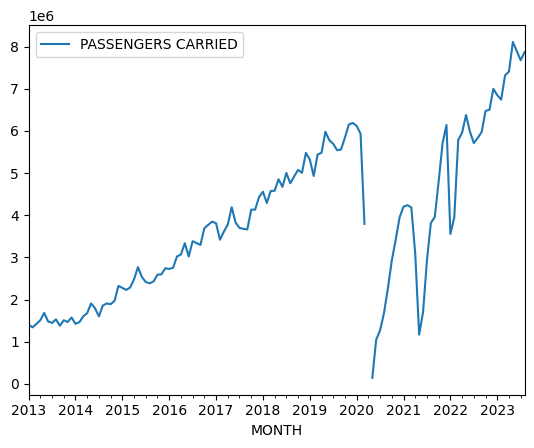

In [4]:
df.plot(x="MONTH", y="PASSENGERS CARRIED")

The sudden dip in PASSENGERS CARRIED cooresponds to COVID-19 period. We specify that as a holiday period to prophet, as the jump from 2020-02-01 to 2022-03-01 seems nearly continuous

In [5]:
lockdowns = pd.DataFrame([
    {'holiday': 'lockdown', 'ds': '2020-03-01', 'lower_window': 0, 'ds_upper': '2022-02-28'}
])
for t_col in ['ds', 'ds_upper']:
    lockdowns[t_col] = pd.to_datetime(lockdowns[t_col])
lockdowns['upper_window'] = (lockdowns['ds_upper'] - lockdowns['ds']).dt.days
lockdowns

,holiday,ds,lower_window,ds_upper,upper_window
0,lockdown,2020-03-01,0,2022-02-28,729


In [6]:
df_clean = df.copy().drop("AIRLINE", axis=1)
df_clean.rename(columns={'MONTH': 'ds', 'PASSENGERS CARRIED': 'y'}, inplace=True)
df_clean.head()

,ds,TOTAL DEPARTURES,HOURS FLOWN,KILOMETRE FLOWN,y,AVAILABLE SEAT KILOMETRE (IN THOUSAND),FREIGHT CARRIED (IN TONNE),MAIL CARRIED (IN TONNE)
0,2013-01-01,10552.0,18655.0,10112.0,1408012.0,1820105.0,6465.0,0.0
1,2013-02-01,9873.0,17374.0,9439.0,1341210.0,1698930.0,6235.0,0.0
2,2013-03-01,11393.0,20093.0,11028.0,1423569.0,1984886.0,6505.0,0.0
3,2013-04-01,11426.0,20084.0,11090.0,1511094.0,1996084.0,5903.0,0.0
4,2013-05-01,11885.0,20779.0,11533.0,1685168.0,2075882.0,7345.0,0.0


# Model Training

We use Prophet model for prediction

In [7]:
scaler = StandardScaler()
m = Prophet(holidays=lockdowns, interval_width=0.95, uncertainty_samples=2000)
for col in (df_clean.columns[1:4].to_list() + df_clean.columns[5:-1].to_list()):
    df_clean[col] = scaler.fit_transform(df_clean[[col]])
    m.add_regressor(col, standardize=False)

In [8]:
train_size = int(0.8 * len(df_clean))
train, test = df_clean[:train_size], df_clean[train_size:]

train = train.copy()
train["y"] = scaler.fit_transform(train[["y"]])
m.fit(train)

16:55:03 - cmdstanpy - INFO - Chain [1] start processing
16:55:03 - cmdstanpy - INFO - Chain [1] done processing


# Model Evaluation

In [9]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [10]:
pred = m.predict(test.drop('y', axis=1))
pred["yhat_lower"] = scaler.inverse_transform(pred[["yhat_lower"]])
pred["yhat_upper"] = scaler.inverse_transform(pred[["yhat_upper"]])
pred.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,FREIGHT CARRIED (IN TONNE),FREIGHT CARRIED (IN TONNE)_lower,FREIGHT CARRIED (IN TONNE)_upper,AVAILABLE SEAT KILOMETRE (IN THOUSAND),...,lockdown,lockdown_lower,lockdown_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-07-01,0.434120,3.511140e+06,3.846973e+06,0.433538,0.434691,0.037473,0.037473,0.037473,-0.057371,...,0.0,0.0,0.0,-0.065763,-0.065763,-0.065763,0.0,0.0,0.0,0.263202
1,2021-08-01,0.430471,4.041387e+06,4.371144e+06,0.428709,0.432230,0.051118,0.051118,0.051118,0.037774,...,0.0,0.0,0.0,-0.076451,-0.076451,-0.076451,0.0,0.0,0.0,0.622987
2,2021-09-01,0.426823,4.239463e+06,4.575342e+06,0.423370,0.430360,0.050926,0.050926,0.050926,0.067045,...,0.0,0.0,0.0,-0.097858,-0.097858,-0.097858,0.0,0.0,0.0,0.751768
3,2021-10-01,0.423292,4.934869e+06,5.255913e+06,0.417895,0.428536,0.067726,0.067726,0.067726,0.191318,...,0.0,0.0,0.0,-0.072308,-0.072308,-0.072308,0.0,0.0,0.0,1.207035
4,2021-11-01,0.419644,5.720203e+06,6.057015e+06,0.412366,0.426942,0.036517,0.036517,0.036517,0.324458,...,0.0,0.0,0.0,0.007056,0.007056,0.007056,0.0,0.0,0.0,1.734494


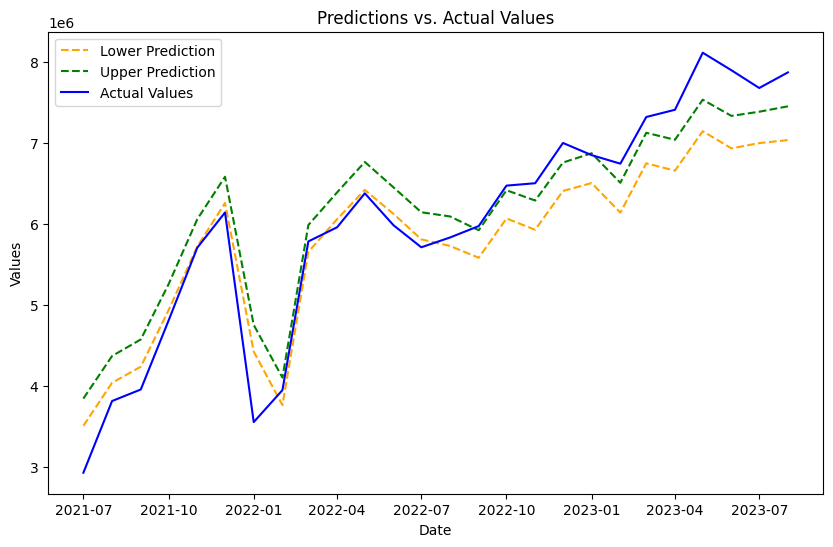

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(pred["ds"], pred["yhat_lower"], label="Lower Prediction", color="orange", linestyle="--")
plt.plot(pred["ds"], pred["yhat_upper"], label="Upper Prediction", color="green", linestyle="--")
plt.plot(test["ds"], test["y"], label="Actual Values", color="blue")
plt.title("Predictions vs. Actual Values")
plt.xlabel("Date")
plt.ylabel("Values")
plt.legend()
plt.show()

In [12]:
mape = mean_absolute_percentage_error(test["y"], (pred["yhat_lower"] + pred["yhat_upper"]) / 2)
print(f"The mean absolute percentage error is {mape}%")

The mean absolute percentage error is 7.0683484408194%
